In [202]:
from typing import TypedDict, List, Union
from langchain_core.messages import HumanMessage, AIMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, START, END
from dotenv import load_dotenv
from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL
from langgraph.prebuilt import create_react_agent
import os
load_dotenv()


True

In [115]:
class AgentState(TypedDict):
    messages: List[Union[HumanMessage, AIMessage]]

api_key = os.getenv("API_KEY")

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", google_api_key = api_key)

In [116]:
# response = llm.invoke("hi")
# response

### Create Script Writer Agent

In [164]:
tavily_tool = TavilySearch(max_results=5)

with open("scriptwriter_instruction.txt", 'r', encoding="utf-8") as file:
        instruction = file.read()

scriptwriter_agent = create_react_agent(llm, 
tools = [tavily_tool],
prompt = instruction)



def scriptwriter_node(state: AgentState)-> AgentState:

    response = scriptwriter_agent.invoke({"messages": state["messages"]})
    updated_messages = response["messages"]

    return {"messages": updated_messages}



test = scriptwriter_agent.invoke({"messages": [HumanMessage(content="hi")]})
test

{'messages': [HumanMessage(content='hi', additional_kwargs={}, response_metadata={}, id='3bb6c616-4a59-4a5e-b230-04f57e52d155'),
  AIMessage(content="Hi! I'm ready to help you create a developer-focused YouTube Short script. What's the product idea or feature you want to promote? Please provide as much detail as possible.", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--adb5faa4-fc98-4ba4-9f97-bbb79483b9be-0')]}

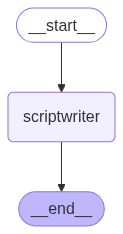

In [165]:
graph = StateGraph(AgentState)
graph.add_node("scriptwriter",scriptwriter_node)
graph.add_edge(START, "scriptwriter")
graph.add_edge("scriptwriter", END)

app = graph.compile()
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))



In [166]:
conversation_history = []

user_input = input("Enter: ")
while user_input != "exit":
    conversation_history.append(HumanMessage(content=user_input))  

    result = app.invoke({"messages": conversation_history})

    conversation_history = result["messages"]  

    print(result["messages"])

    user_input = input("Enter: ")

[HumanMessage(content='give me a script about  python', additional_kwargs={}, response_metadata={}, id='68c1ac3c-9565-4e07-b818-cd2362f0f13d'), AIMessage(content="```text\n[0-2s] Frustrated with verbose code?\n[2-5s] Python offers a clean, readable syntax that boosts developer productivity.\n[5-10s] Its dynamic typing and extensive libraries like NumPy and Pandas simplify complex tasks.\n[10-15s] From web development with Django and Flask...\n[15-20s] ...to data science and machine learning, Python's versatility shines.\n[20-25s] Need to automate tasks? Python scripting gets it done efficiently.\n[25-30s] Join millions of developers leveraging Python's power.\n[30-35s] Start learning today and unlock endless possibilities!\n[35-38s] Find beginner-friendly tutorials in the description.\n```", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--551

### Add  Visualizer Agent

In [163]:
with open("visualizer_instruction.txt", 'r', encoding="utf-8") as file:
        instruction = file.read()

visualizer_agent = create_react_agent(llm, prompt = instruction, tools =[])


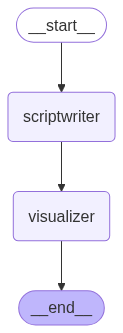

In [183]:
def visualizer_node(state: AgentState)-> AgentState:

    response = visualizer_agent.invoke({"messages": state["messages"]})
    updated_messages = response["messages"]

    return {"messages": updated_messages}

####### build graph with new agent

graph = StateGraph(AgentState)
graph.add_node("scriptwriter",scriptwriter_node)
graph.add_edge(START, "scriptwriter")
graph.add_node("visualizer", visualizer_node)
graph.add_edge("scriptwriter", "visualizer")
graph.add_edge("visualizer", END)

app = graph.compile()
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))


In [175]:
conversation_history = []

user_input = input("Enter: ")
while user_input != "exit":
    conversation_history.append(HumanMessage(content=user_input))  

    result = app.invoke({"messages": conversation_history})

    conversation_history = result["messages"]  

    print(result["messages"])

    user_input = input("Enter: ")

ENTERED VISUALIZER NODE
[HumanMessage(content='ggive me youtube short about java', additional_kwargs={}, response_metadata={}, id='e52e7858-f45f-4680-bbe0-09085dca9ceb'), AIMessage(content='```text\n(Upbeat, fast-paced music intro)\n\n**[0-2 seconds] Visual: Quick cuts of Java code snippets, logos of popular Java frameworks (Spring, etc.), and the word "JAVA" in bold text.**\n\n**[Narrator]:** Still using Java? Don\'t let anyone tell you it\'s outdated!\n\n**[2-7 seconds] Visual: A graph showing Java\'s continued usage in enterprise environments. A simple "Hello, World!" Java code example appears.**\n\n**[Narrator]:** Java powers massive enterprise applications and modern backends. Its stability and huge community are unmatched.\n\n**[7-15 seconds] Visual: Code example demonstrating a key Java feature (e.g., Streams, Lambdas).**\n\n**[Narrator]:** Modern Java includes powerful features like Streams and Lambdas for concise and efficient code.\n\n**[15-25 seconds] Visual: Showcase popula

### Add Formatter Agent

In [182]:
formatter_agent = create_react_agent(llm,
prompt = """Combine the script you created and the visual concepts 
 into the final Markdown format requested previously (Hook, Script & Visuals table, Visual Notes, CTA)""",
tools =[])

def formatter_node(state: AgentState)-> AgentState:

    response = formatter_agent.invoke({"messages": state["messages"]})
    updated_messages = response["messages"]

    return {"messages": updated_messages}


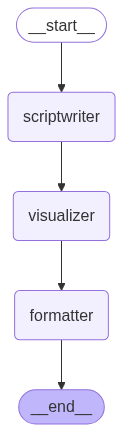

In [177]:
graph = StateGraph(AgentState)
graph.add_node("scriptwriter",scriptwriter_node)
graph.add_edge(START, "scriptwriter")
graph.add_node("visualizer", visualizer_node)
graph.add_edge("scriptwriter", "visualizer")
graph.add_node("formatter", formatter_node)
graph.add_edge("visualizer", "formatter")
graph.add_edge("formatter", END)

app = graph.compile()
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [181]:
conversation_history = []

user_input = input("Enter: ")
while user_input != "exit":
    conversation_history.append(HumanMessage(content=user_input))  

    result = app.invoke({"messages": conversation_history})

    conversation_history = result["messages"]  

    print(result["messages"])

    user_input = input("Enter: ")

ENTERED VISUALIZER NODE
ENTERED VISUALIZER NODE
[HumanMessage(content='give me youtube short about java', additional_kwargs={}, response_metadata={}, id='01c9dffe-861a-4bba-8369-87ab36b5e82d'), AIMessage(content="```text\n(Hook, 1-2s) Frustrated with verbose code?\n\n(Narrative, 15-20s) Java's great, but sometimes you need more concise syntax. Enter Project Lombok! It's a library that uses annotations to auto-generate boilerplate code like getters, setters, constructors, and toString methods.\n\n(Example, 10-15s) Just add the @Data annotation to your class, and Lombok handles the rest. No more manually writing repetitive code! This cleans up your classes and reduces errors.\n\n(Benefits, 5-10s) Spend less time on boilerplate and more time on actual logic. Lombok integrates seamlessly with most IDEs.\n\n(Call to Action, 2-3s) Check the link below for Lombok setup and usage!\n```", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'fin

#### Add conditional edge and deciding node so that agents are used only when needed

In [199]:
def decide_whats_next(state: AgentState)->AgentState:
    user_msg = state["messages"][-1].content.lower()

    if "script" in user_msg or "youtube short" in user_msg:
        return "scriptwriter"  
    else:
        return "chatbot"
    
def chatbot_node(state: AgentState)-> AgentState:
    response = llm.invoke(state["messages"])
    state["messages"].append(response)
    return state

def route_node(state: AgentState) -> AgentState:
    return state



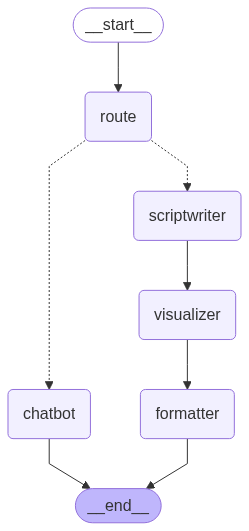

In [200]:
graph = StateGraph(AgentState)
graph.add_node("scriptwriter",scriptwriter_node)

graph.add_node("route", route_node)
graph.add_edge(START, "route")

graph.add_conditional_edges(
    "route",
    decide_whats_next,
    {
        "scriptwriter": "scriptwriter",
        "chatbot": "chatbot"
    }
)
graph.add_node("chatbot", chatbot_node)

graph.add_node("visualizer", visualizer_node)
graph.add_edge("scriptwriter", "visualizer")

graph.add_node("formatter", formatter_node)
graph.add_edge("visualizer", "formatter")

graph.add_edge("formatter", END)
graph.add_edge("chatbot", END)

app = graph.compile()
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [203]:
conversation_history = []

user_input = input("Enter: ")
while user_input != "exit":
    conversation_history.append(HumanMessage(content=user_input))  

    result = app.invoke({"messages": conversation_history})

    conversation_history = result["messages"]  

    print(result["messages"])

    user_input = input("Enter: ")

[HumanMessage(content='hi my name is christina', additional_kwargs={}, response_metadata={}), AIMessage(content="Hi Christina, it's nice to meet you! How can I help you today?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--dfeadb3a-51cf-4a85-8076-80d085b0a55c-0')]
[HumanMessage(content='hi my name is christina', additional_kwargs={}, response_metadata={}, id='cd3fd9ff-1bc0-4561-8b4c-f04d15b21ce2'), AIMessage(content="Hi Christina, it's nice to meet you! How can I help you today?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--dfeadb3a-51cf-4a85-8076-80d085b0a55c-0'), HumanMessage(content='give me a youtube short about java', additional_kwargs={}, response_metadata={}, id='aa79d29a-5fc3-4809-8e2

##### Takeaways:

First prompt: greeting the model and introducing my name (no youtube agents involved) <br>
Second prompt: asking model to generate a youtube short about java (all three agents involved)<br>
Third prompt: asking model if it remembers my name and it does thanks to the conversation history<br>

##### Saving convo to text file:

In [204]:
with open("logging.txt", "w") as file:
    file.write("Your Conversation Log:\n")
    
    for message in conversation_history:
        if isinstance(message, HumanMessage):
            file.write(f"You: {message.content}\n")
        elif isinstance(message, AIMessage):
            file.write(f"AI: {message.content}\n\n")
    file.write("End of Conversation")

 references: <br>
[chatbot](https://github.com/iamvaibhavmehra/LangGraph-Course-freeCodeCamp/blob/main/Agents/Memory_Agent.py) <br>
[multi agent communication](https://github.com/langchain-ai/langgraph/blob/main/docs/docs/tutorials/multi_agent/multi-agent-collaboration.ipynb) <br>
[langgraph basics](https://www.youtube.com/watch?v=jGg_1h0qzaM&t=7564s) <br>
[docs](https://langchain-ai.github.io/langgraph/tutorials/get-started/2-add-tools/#5-create-a-function-to-run-the-tools) <br>